#### Importing Libraries for Data Analysis and Visualization

In [2]:
!pip install icecream
!pip install scikit-learn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import missingno as msno

In [3]:
import pandas as pd
from icecream import ic

try:
    income_df = pd.read_csv('dataset/income.csv')
    ic('Dataset loaded successfully')
except Exception as e:
    ic(f'Error loading dataset: {e}')

ic| 'Dataset loaded successfully'


In [4]:
# Display the shape of the DataFrame
print(f'Shape : {income_df.shape}')

# Display important information about the DataFrame
print(income_df.info())

Shape : (48842, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [5]:
# Display the first 5 values of income.csv
print(income_df.head())
print('--------------------------------------------------------------------------------')

# Display the last 5 values of income.csv
print(income_df.tail())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

#### Step 1 : Preprocessing the Data

In [6]:
# Check for duplicates in the DataFrame
duplicates = income_df.duplicated().sum()
print(f'Number of duplicates : {duplicates}')

# Drop duplicates from the DataFrame
income_df = income_df.drop_duplicates().reset_index(drop=True)

print(f"The number of duplicates has been removed. The new shape of the DataFrame is: {income_df.shape}")

Number of duplicates : 52
The number of duplicates has been removed. The new shape of the DataFrame is: (48790, 15)


In [7]:
# Display the number of missing values in each column
print("Missing Values\n-----------------------")
print((income_df.isin(['?'])).sum())

Missing Values
-----------------------
age                   0
workclass          2795
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2805
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      856
income                0
dtype: int64


##### Handling missing values

In [8]:
# Replace '?' with NaN for data visualization and future imputation purposes
income_missing_df = income_df.replace('?',np.nan)

<Axes: >

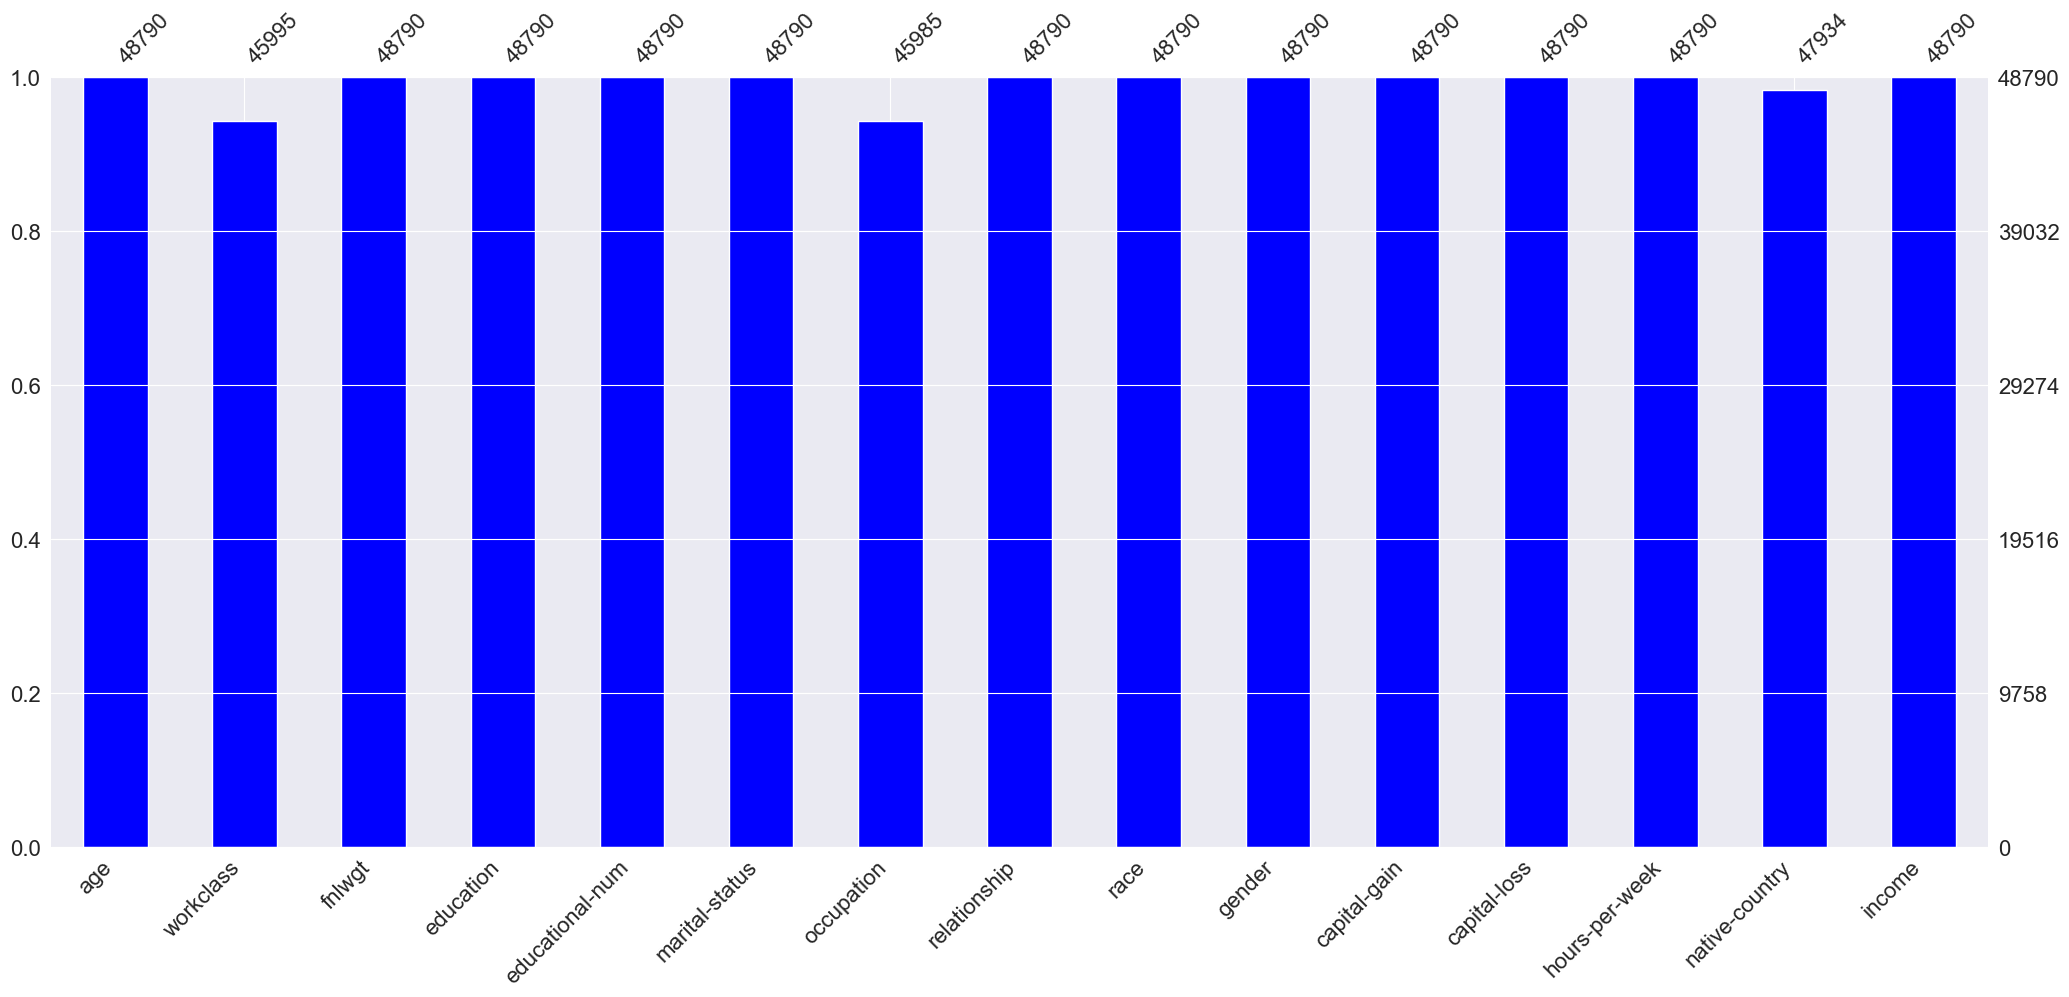

In [9]:
msno.bar(income_missing_df, color='blue')

<Axes: >

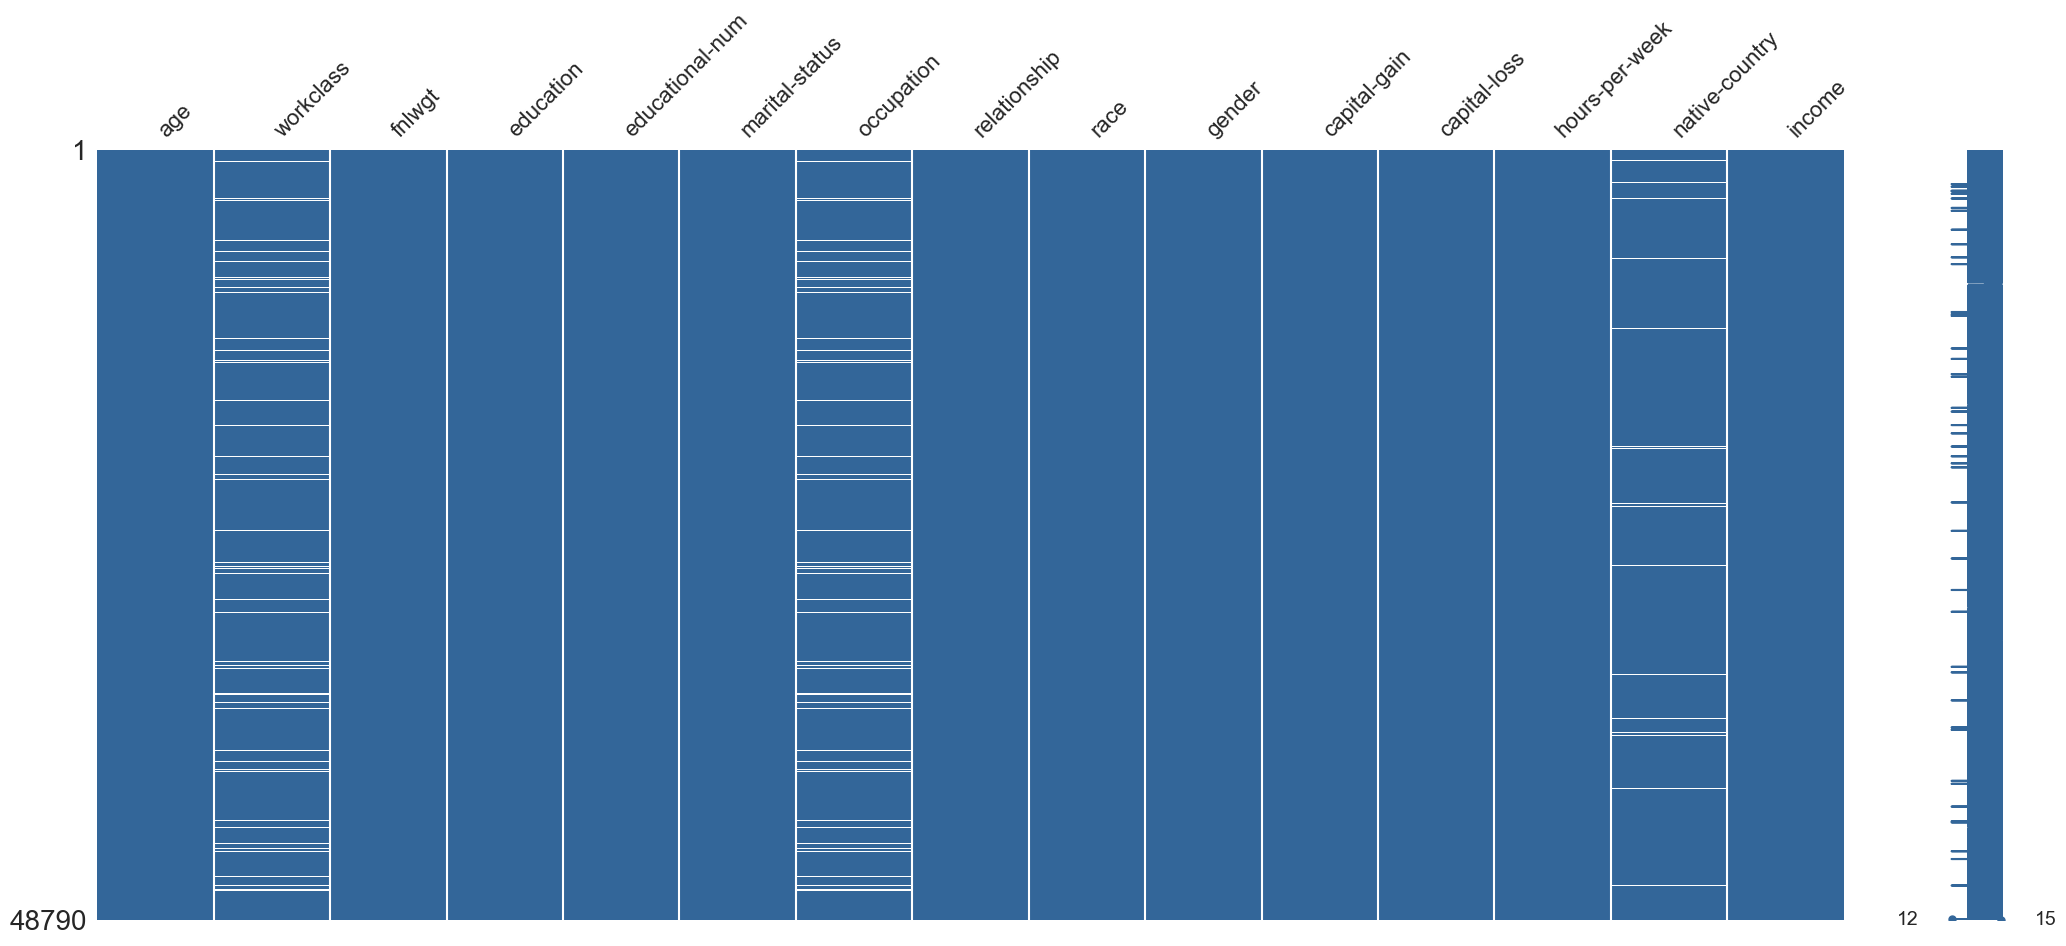

In [10]:
# Visualize the missing values in the DataFrame, and the correlation between the columns
msno.matrix(income_missing_df, color=(0.2, 0.4, 0.6))

#### Commentary
According to the bar chart above, the columns 'workclass', 'native-country', and 'occupation' have a significant number of missing values. The cooccurrence of the missing values in the 'workclass' and 'occupation' columns suggests that these two columns are related. This means that when the 'workclass' is missing, the 'occupation' is also likely to be missing, and vice versa. The 'native-country' column also has a significant number of missing values, but it does not appear to be correlated with the other two columns, as the missing values of this column seem to be randomly distributed across the dataset. The barchart sample of 200 rows displayed below helps to visualize the missing values more clearly. Indeed, it allows for a better understanding of how missing values are distributed in the dataset, and also helps to observe the point made previously

<Axes: >

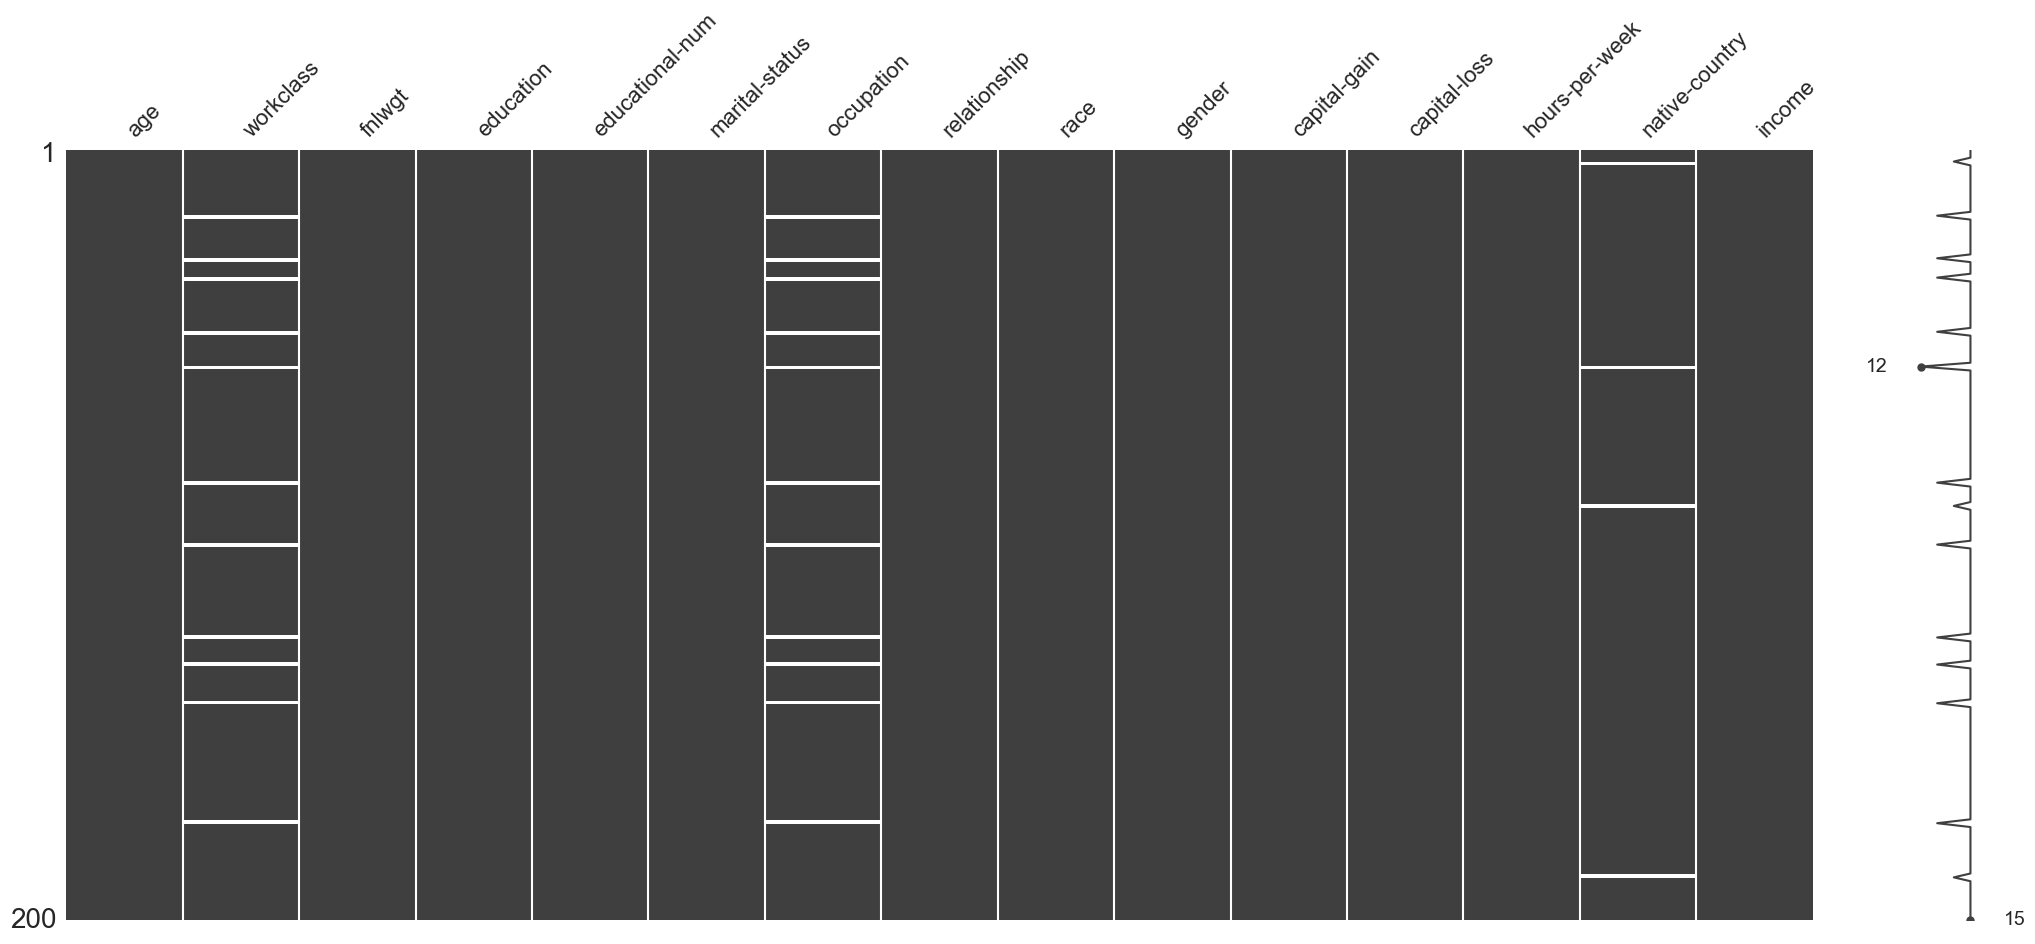

In [11]:
# Display a sample of 200 rows to visualize the missing values
msno.matrix(income_missing_df.sample(200))

In [12]:
missing_values_workclass = income_df[income_df['workclass'] == '?']['workclass'].count()/income_df['workclass'].count()

print(f'{round(missing_values_workclass * 100, 2)}% of the values of "workclass" are missing.')

missing_values_country = income_df[income_df['native-country'] == '?']['native-country'].count()/income_df['native-country'].count()

print(f'{round(missing_values_country * 100, 2)}% of the values of "native-country" are missing.')

missing_values_occupation = income_df[income_df['occupation'] == '?']['occupation'].count()/income_df['occupation'].count()

print(f'{round(missing_values_occupation * 100, 2)}% of the values of "occupation" are missing.')

5.73% of the values of "workclass" are missing.
1.75% of the values of "native-country" are missing.
5.75% of the values of "occupation" are missing.


<Axes: >

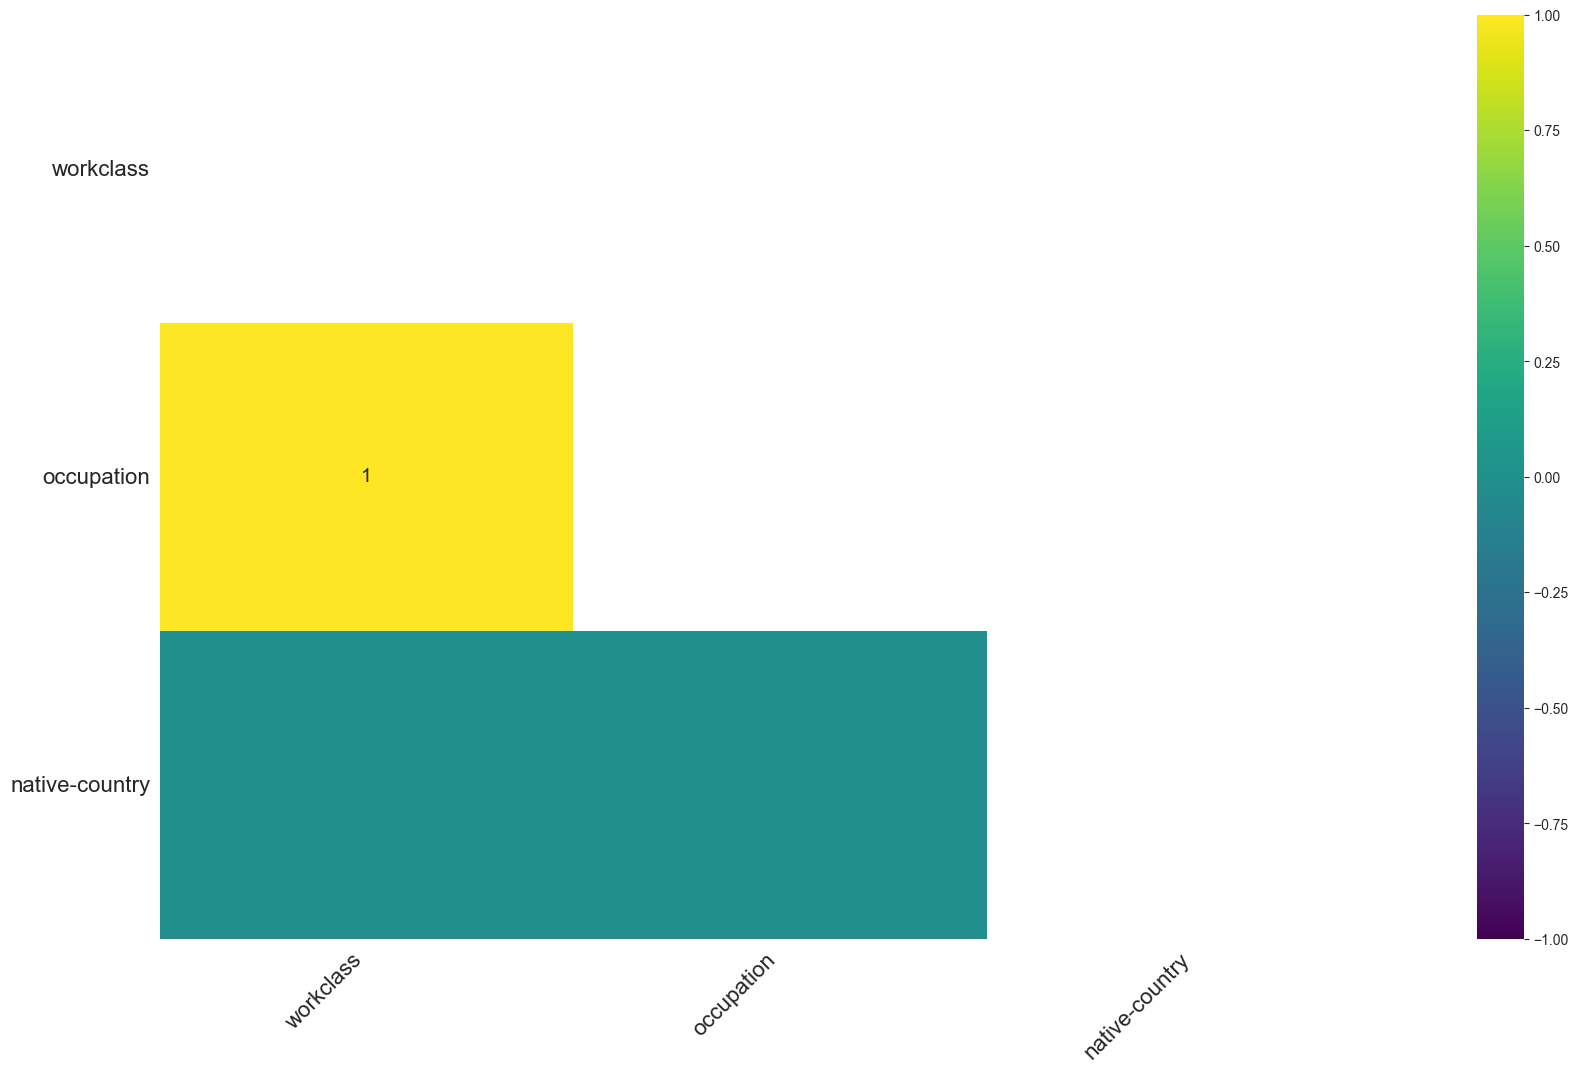

In [13]:
msno.heatmap(income_missing_df, cmap='viridis')

#### Commentary
The missing values in both the 'workclass' and 'occupation' columns appear to be highly correlated. Indeed, the following heatmap demonstrates a perfect and positive correlation between these two columns. This information indicates that there is a relationship between their missing values. We can therefore infer that in cases when an individual's employment class is unknown, their occupation may also be unknown. Thus, the missing values are non-random, which led us to introduce a new category called 'unknown' to impute those values.

In [14]:
missing_values_columns = ['workclass', 'native-country', 'occupation']

for col in missing_values_columns:
    print(f'The different values that can be taken by the column {col} : {income_df[col].unique()}\n')

The different values that can be taken by the column workclass : ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

The different values that can be taken by the column native-country : ['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti' 'El-Salvador'
 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India' 'Cambodia'
 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada' 'Portugal'
 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica' 'Ecuador'
 'Yugoslavia' 'Hungary' 'Hong' 'Greece' 'Trinadad&Tobago'
 'Outlying-US(Guam-USVI-etc)' 'France' 'Holand-Netherlands']

The different values that can be taken by the column occupation : ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Hand

In [15]:
mode_value_workclass = income_df['workclass'].mode().iloc[0]
mode_value_country = income_df['native-country'].mode().iloc[0]
mode_value_occ = income_df['occupation'].mode().iloc[0]

print(f"The frequency of the mode in the column 'workclass' is {round(income_df[income_df['workclass'] == mode_value_workclass]['workclass'].count() / income_df['workclass'].count() * 100, 2)}%.")

print(f"The frequency of the mode in the column 'native-country' is {round(income_df[income_df['native-country'] == mode_value_country]['native-country'].count() / income_df['native-country'].count() * 100, 2)}%.")

print(f"The frequency of the mode in the column 'occupation' is {round(income_df[income_df['occupation'] == mode_value_occ]['occupation'].count() / income_df['occupation'].count() * 100, 2)}%.")

The frequency of the mode in the column 'workclass' is 69.4%.
The frequency of the mode in the column 'native-country' is 89.76%.
The frequency of the mode in the column 'occupation' is 12.64%.


In [16]:
# Before imputing the missing values in the 'workclass' column, check the second most frequent value in the column native-country
second_highest = income_df['native-country'].value_counts().index[1]

percentage = (income_df['native-country'][income_df['native-country'] == second_highest].count() / income_df['native-country'].count()) * 100

# We look for the second most frequent value in the column 'native-country' to check if it should be imputed with the mode value or not, or if it should be imputed with a new class 'unknown'
print(f'The value with the second highest frequency in the column "native-country" is "{second_highest}" with a frequency of {round(percentage,2)}%.')

The value with the second highest frequency in the column "native-country" is "Mexico" with a frequency of 1.93%.


In [17]:
print('Before\n--------------------------------------------------')
print(income_df['native-country'].head(20))

# Impute the missing values in the 'workclass' column with a new Unknown class
income_df['native-country'] = income_df['native-country'].apply(lambda x: 'Unknown' if x == '?' else x)
print('After\n--------------------------------------------------')
print(income_df['native-country'].head(20))

Before
--------------------------------------------------
0     United-States
1     United-States
2     United-States
3     United-States
4     United-States
5     United-States
6     United-States
7     United-States
8     United-States
9     United-States
10    United-States
11    United-States
12    United-States
13    United-States
14    United-States
15    United-States
16    United-States
17    United-States
18    United-States
19                ?
Name: native-country, dtype: object
After
--------------------------------------------------
0     United-States
1     United-States
2     United-States
3     United-States
4     United-States
5     United-States
6     United-States
7     United-States
8     United-States
9     United-States
10    United-States
11    United-States
12    United-States
13    United-States
14    United-States
15    United-States
16    United-States
17    United-States
18    United-States
19          Unknown
Name: native-country, dtype: object


#### Commentary

According to the previous heatmap, the native-country column appears to have randomly missing values. The mode in this column is dominant with a frequency of 89.76%, which indicates that the column is largely unbalanced. The most frequent variable after the mode, 'Mexico', accounts for 1.93% of the occurrences. Furthermore, 1.75% of the values in this column are missing, which is close to the previously mentioned proportion of 1.93%. Thus, the missing values are numerous enough to be treated as a separate category. Given these observations, we chose to impute with an arbitrary value 'unknown' to preserve the existing distribution and avoid reinforcing the already dominant mode. 

In [18]:
print('Before\n--------------------------------------------------')
print(income_df['workclass'].head(20))

income_df['workclass'] = income_df['workclass'].apply(lambda x: 'Unknown' if x == '?' else x)

print('After\n--------------------------------------------------')
print(income_df['workclass'].head(20))

Before
--------------------------------------------------
0              Private
1              Private
2            Local-gov
3              Private
4                    ?
5              Private
6                    ?
7     Self-emp-not-inc
8              Private
9              Private
10             Private
11         Federal-gov
12             Private
13                   ?
14             Private
15             Private
16           State-gov
17             Private
18             Private
19             Private
Name: workclass, dtype: object
After
--------------------------------------------------
0              Private
1              Private
2            Local-gov
3              Private
4              Unknown
5              Private
6              Unknown
7     Self-emp-not-inc
8              Private
9              Private
10             Private
11         Federal-gov
12             Private
13             Unknown
14             Private
15             Private
16           State-gov
17 

In [19]:
print('Before\n--------------------------------------------------')
print(income_df['occupation'].head(20))

income_df['occupation'] = income_df['occupation'].apply(lambda x: 'Unknown' if x == '?' else x)

print('After\n--------------------------------------------------')
print(income_df['occupation'].head(20))

Before
--------------------------------------------------
0     Machine-op-inspct
1       Farming-fishing
2       Protective-serv
3     Machine-op-inspct
4                     ?
5         Other-service
6                     ?
7        Prof-specialty
8         Other-service
9          Craft-repair
10    Machine-op-inspct
11         Adm-clerical
12         Adm-clerical
13                    ?
14    Machine-op-inspct
15      Exec-managerial
16        Other-service
17         Adm-clerical
18    Machine-op-inspct
19       Prof-specialty
Name: occupation, dtype: object
After
--------------------------------------------------
0     Machine-op-inspct
1       Farming-fishing
2       Protective-serv
3     Machine-op-inspct
4               Unknown
5         Other-service
6               Unknown
7        Prof-specialty
8         Other-service
9          Craft-repair
10    Machine-op-inspct
11         Adm-clerical
12         Adm-clerical
13              Unknown
14    Machine-op-inspct
15      Exec-

##### Discretization of selected columns

**Hypothesis :** The columns "education" and "educational-num" refer to the same information

In [20]:
print(income_df['education'].head())
print('===================================================')
print(income_df['educational-num'].head())

0            11th
1         HS-grad
2      Assoc-acdm
3    Some-college
4    Some-college
Name: education, dtype: object
0     7
1     9
2    12
3    10
4    10
Name: educational-num, dtype: int64


In [21]:
print(income_df['education'].unique())
print('===================================================')
print(income_df['educational-num'].unique())

['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
[ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]


In [24]:
# Create a dictionary to map education levels to ordinal variables.

education_dict = {
    'Preschool' : 1,
    '1st-4th':2,
    '5th-6th' : 3,
    '7th-8th' : 4,
    '9th' : 5,
    '10th' : 6,
    '11th' : 7,
    '12th' : 8,
    'HS-grad' : 9,
    'Some-college' : 10,
    'Assoc-voc' : 11,
    'Assoc-acdm' : 12,
    'Bachelors' : 13,
    'Masters' : 14,
    'Prof-school' : 15,
    'Doctorate' : 16
}

# Map the education levels to ordinal variables
income_df['education_mapped'] = income_df['education'].map(education_dict)

# Compute the correlation between the 'education' column and the 'educational-num' column
correlation = income_df['education'].map(education_dict).corr(income_df['educational-num'])

# Display the correlation
print(f'The correlation between the "education" and "educational-num" columns is {str(correlation)}.')

The correlation between the "education" and "educational-num" columns is 1.0.


#### Commentary
The correlation is perfect, linear, and positive. Thus, we can confirm that the "education" and "educational-num" columns refer to the same information. We can continue our preprocessing process. We will keep the "education" column and drop the "educational-num" column eventually.

In [25]:
def simplify_education(education):
    """
    Simplify the education level by grouping similar levels together.
    :param education: education level as a string
    :return: education level as a string
    """
    if education in ['1st-4th', 'Preschool']:
        return 'Elementary-school'
    elif education in ['5th-6th','7th-8th']:
        return  'Middle-school'
    elif education in ['9th', '10th', '11th', '12th']:
        return 'HS-no-diploma'
    else:
        return education

print('Before\n--------------------------------------------------')
print(income_df['education'].unique())

# Apply the function to the 'education' column to create a new column 'education-grouped'
income_df['education-grouped'] = income_df['education'].apply(lambda x: simplify_education(x))

print('After\n--------------------------------------------------')
print(income_df['education-grouped'].unique())

Before
--------------------------------------------------
['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
After
--------------------------------------------------
['HS-no-diploma' 'HS-grad' 'Assoc-acdm' 'Some-college' 'Prof-school'
 'Middle-school' 'Bachelors' 'Masters' 'Doctorate' 'Assoc-voc'
 'Elementary-school']


In [27]:
def simplify_working_hours(working_hours):
    """
    Simplify the working hours by grouping them into ranges.
    :param working_hours: working hours as a string
    :return: working hours as a string representing the range
    """
    working_hours = int(working_hours)
    if working_hours < 20:
        return '0–19'
    elif working_hours < 40:
        return '20–39'
    elif working_hours < 60:
        return '40–59'
    elif working_hours < 80:
        return '60–79'
    else:
        return '80+'


print('Before\n--------------------------------------------------')
print(income_df['hours-per-week'].unique())

income_df['hours-per-week-grouped'] = income_df['hours-per-week'].apply(lambda x: simplify_working_hours(x))


print('After\n--------------------------------------------------')
print(income_df['hours-per-week-grouped'].unique())


Before
--------------------------------------------------
[40 50 30 32 10 39 35 48 25 20 45 47  6 43 90 54 60 38 36 18 24 44 56 28
 16 41 22 55 14 33 37  8 12 70 15 75 52 84 42 80 68 99 65  5 17 72 53 29
 96 21 46  3  1 23 49 67 76  7  2 58 26 34  4 51 78 63 31 92 77 27 85 13
 19 98 62 66 57 11 86 59  9 64 73 61 88 79 89 74 69 87 97 94 82 91 81 95]
After
--------------------------------------------------
['40–59' '20–39' '0–19' '80+' '60–79']


#### Commentary
We decided to discretize the hours-per-week variable. First, this approach facilitates exploratory data analysis. Indeed, due to the variability of the values in this column, using its original format risks creating unnecessary noise. Whereas grouping them allows us to observe the relationships between working hours per week and other variables more clearly.

In [32]:
mode_value_capital_gain = income_df['capital-gain'].mode().iloc[0]

print(f"The frequency of the mode in the column 'capital-gain' is {round(income_df[income_df['capital-gain'] == mode_value_capital_gain]['capital-gain'].count() / income_df['capital-gain'].count() * 100, 2)}%.")

The frequency of the mode in the column 'capital-gain' is 91.73%.


In [30]:
print(f"There are {income_df['capital-gain'].nunique()} unique values in the 'capital-gain' columns.")
print("Before\n--------------------------------------------------")
print(income_df['capital-gain'].unique())

# Simplify the 'capital-gain' column to facilitate analysis
income_df['capital-gain-grouped'] = income_df['capital-gain'].apply(lambda x: 'Yes' if x > 0 else 'No')

print("After\n--------------------------------------------------")
print(income_df['capital-gain-grouped'].unique())

There are 123 unique values in the 'capital-gain' columns.
Before
--------------------------------------------------
[    0  7688  3103  6418  7298  3908 14084  5178 15024 99999  2597  2907
  4650  6497  1055  5013 27828  4934  4064  3674  2174 10605  3418   114
  2580  3411  4508  4386  8614 13550  6849  2463  3137  2885  2964  1471
 10566  2354  1424  1455  3325  4416 25236   594  2105  4787  2829   401
  4865  1264  1506 10520  3464  2653 20051  4101  1797  2407  3471  1086
  1848 14344  1151  2993  2290 15020  9386  2202  3818  2176  5455 11678
  7978  7262  6514 41310  3456  7430  2414  2062 34095  1831  6723  5060
 15831  2977  2346  3273  2329  9562  2635  4931  1731  6097   914  7896
  5556  1409  3781  3942  2538  3887 25124  7443  5721  1173  4687  6612
  6767  2961   991  2036  2936  2050  1111  2228 22040  3432  6360  2009
  1639 18481  2387]
After
--------------------------------------------------
['No' 'Yes']


#### Commentary
We decided to binarize the capital-gain variable to better assess its relevance in the dataset. This approach classifies respondents based on whether they received a capital gain or not. This decision was made following a few observations: the frequency of people who received no capital gain is 91.73%, and there is a large variability in the column, with 123 distinct classes. Therefore, the new variable capital_gain_grouped subdivides the original 'capital-gain' variable into two classes: 'Yes' and 'No'. 'Yes' indicates that the person received a capital gain, while 'No' means they did not.

In [35]:
mode_value_capital_loss = income_df['capital-loss'].mode().iloc[0]

print(f"The frequency of the mode in the column 'capital-loss' is {round(income_df[income_df['capital-loss'] == mode_value_capital_loss]['capital-loss'].count() / income_df['capital-loss'].count() * 100, 2)}%.")

The frequency of the mode in the column 'capital-loss' is 95.32%.


In [34]:
print(f"There are {income_df['capital-loss'].nunique()} different classes in the 'capital-loss' column.")

print("Before\n--------------------------------------------------")
print(income_df['capital-loss'].unique())

# Simplify the 'capital-loss' column to facilitate analysis
income_df['capital-loss-grouped'] = income_df['capital-loss'].apply(lambda x: 'Yes' if x > 0 else 'No')

print("Après\n--------------------------------------------------")
print(income_df['capital-loss-grouped'].unique())

There are 99 different classes in the 'capital-loss' column.
Before
--------------------------------------------------
[   0 1721 1876 2415 1887  625 1977 2057 1429 1590 1485 2051 2377 1672
 1628 1902 1602 1741 2444 1408 2001 2042 1740 1825 1848 1719 3004 2179
 1573 2205 1258 2339 1726 2258 1340 1504 2559 1668 1974 1980 1564 2547
 2002 1669 1617  323 3175 2472 2174 1579 2129 1510 1735 2282 1870 1411
 1911 1651 1092 1762 2457 2231 2238  653 1138 2246 2603 2392 1944 1380
 2465 1421 3770 1594  213 2149 2824 1844 2467 2163 1816 1648 2206 2352
  419 1539  880  810  974 4356 2489 1755 3683 2267 2080  155 3900 2201
 2754]
Après
--------------------------------------------------
['No' 'Yes']


#### Commentary
Just like the capital-gain variable, we discretized the capital-loss variable. Given its 99 distinct values and the fact that approximately 95.32% of respondents did not incur any capital loss, the variable was converted into a binary classification : Yes and No. More precisely, the 'Yes' class means that a person received a capital loss, while 'No' demonstrates the opposite.

In [36]:
def group_country(country):
    """
    Group countries into regions for better analysis.
    :param country: country name as a string
    :return: continent of which the country is a part
    """
    if country in ['United-States', 'Canada', 'Mexico']:
        return 'North America'

    elif country in ['Guatemala', 'Honduras', 'Nicaragua', 'El-Salvador',
                     'Cuba', 'Dominican-Republic', 'Haiti', 'Jamaica',
                     'Puerto-Rico', 'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc']:
        return 'Central America / Caribbean'

    elif country in ['Columbia', 'Ecuador', 'Peru']:
        return 'South America'

    elif country in ['Ireland', 'England', 'Scotland', 'Germany',
                     'France', 'Portugal', 'Italy', 'Greece', 'Poland',
                     'Hungary', 'Yugoslavia', 'Holand-Netherlands']:
        return 'Europe'

    elif country in ['Philippines', 'Vietnam', 'Thailand',
                     'Cambodia', 'Laos', 'Taiwan', 'China',
                     'Japan', 'India', 'Iran', 'Hong']:
        return 'Asia'
    elif country == 'Unknown':
        return country

    else:
        return 'Other'


print('Avant\n--------------------------------------------------')
print(income_df['native-country'].unique())

income_df['country-grouped'] = income_df['native-country'].apply(lambda x: group_country(x))

print('Après\n--------------------------------------------------')
print(income_df['country-grouped'].unique())

Avant
--------------------------------------------------
['United-States' 'Unknown' 'Peru' 'Guatemala' 'Mexico'
 'Dominican-Republic' 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti'
 'El-Salvador' 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India'
 'Cambodia' 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada'
 'Portugal' 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica'
 'Ecuador' 'Yugoslavia' 'Hungary' 'Hong' 'Greece' 'Trinadad&Tobago'
 'Outlying-US(Guam-USVI-etc)' 'France' 'Holand-Netherlands']
Après
--------------------------------------------------
['North America' 'Unknown' 'South America' 'Central America / Caribbean'
 'Europe' 'Asia' 'Other']
